# **i implemented the last version of the paper, where i train the layer then i fine-tune all the network, over a bunch of SNRs**

In [18]:
import os

# Optional: Set specific GPU (e.g., GPU 3); Kaggle typically gives you 1 GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0  # Only 1 GPU on Kaggle
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Hide TF logs

# Ensure TensorFlow and Sionna are installed
try:
    import sionna.phy
except ImportError:
    print("Installing Sionna...")
    !pip install -q sionna
    import importlib
    importlib.invalidate_caches()
    import sionna.phy

# TensorFlow GPU setup
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Avoid TensorFlow logging warnings
tf.get_logger().setLevel('ERROR')

# Set seed for reproducibility
sionna.phy.config.seed = 42
print("K")


K


In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {[gpu.name for gpu in gpus]}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optional: restrict visible devices
        tf.config.set_visible_devices(gpus[0], 'GPU')  # use only first GPU
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Using CPU.")

Available GPUs: ['/physical_device:GPU:0']


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model, Layer
from tensorflow.keras.layers import Dense, LayerNormalization

import tempfile, shutil, pickle, glob, json, time

from sionna.phy.channel import RayleighBlockFading, OFDMChannel, FlatFadingChannel, KroneckerModel
from sionna.phy.mimo import StreamManagement, lmmse_equalizer
from sionna.phy.ofdm import ResourceGrid, ResourceGridMapper, RemoveNulledSubcarriers,ResourceGridDemapper, LSChannelEstimator, LMMSEEqualizer
from sionna.phy.utils import ebnodb2no, insert_dims, log10, expand_to_rank, sim_ber, PlotBER, compute_ser, compute_ber
from sionna.phy.mapping import Mapper, Demapper, SymbolDemapper,BinarySource, QAMSource
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
# from sionna.phy.channel.tr38901 import AntennaArray, CDL

**Massive MIMO, OFDM(10, 128), ANT(2, 128), SNR[15 ~ -5], Without outputLayer, alpha/beta vector**

In [21]:
CARRIER_FREQUENCY = 3.5e9  # Hz

DELAY_SPREAD = 300e-9  # s
NUM_TX_ANT = 16
NUM_RX_ANT = 64
NUM_TX = 1  # UEs
NUM_RX = 1  # BS
FFT_SIZE = 64
NUM_OFDM_SYMBOLS = 14
BITS_PER_SYMBOL = 4  # 16-QAM

STREAM_MANAGER = StreamManagement([[1]], num_streams_per_tx= NUM_TX_ANT)
CODERATE=1/2
BATCH_SIZE = 64

In [22]:
RESOURCE_GRID= ResourceGrid(
            num_ofdm_symbols=NUM_OFDM_SYMBOLS,
            fft_size = FFT_SIZE,
            subcarrier_spacing=30e3,
            num_tx = NUM_TX,
            num_streams_per_tx = NUM_TX_ANT,
            pilot_pattern="kronecker",
            pilot_ofdm_symbol_indices=[2, 8]
        )

In [23]:
@tf.function(jit_compile=True)
def complex_to_real_matrix(H):
    """Convertit la matrice complexe H en forme réelle étendue selon le papier.

    Args:
        H : [..., Nrx, Ntx], tf.complex64

    Returns:
        H_real : [..., 2*Nrx, 2*Ntx], tf.float32
    """
    H_real = tf.math.real(H)
    H_imag = tf.math.imag(H)

    # Construction de la matrice bloc [[R, -I], [I, R]]
    top = tf.concat([H_real, -H_imag], axis=-1)
    bottom = tf.concat([H_imag, H_real], axis=-1)
    H_real_expanded = tf.concat([top, bottom], axis=-2)

    return H_real_expanded

@tf.function(jit_compile=True)
def complex_to_real_vector(y):
    """Convertit le vecteur complexe y en forme réelle étendue.

    Args:
        y : [..., Nrx], tf.complex64

    Returns:
        y_real : [..., 2*Nrx], tf.float32
    """
    return tf.concat([tf.math.real(y), tf.math.imag(y)], axis=-1)

In [24]:
@tf.function(jit_compile=True)
def real_to_complex(x):
    """Convertit un vecteur réel étendu en complexe
    Args:
        y : [..., 2Ntx,1], tf.complex64

    Returns:
        y_complex : [..., Nrx, 1], tf.float32
    """
    x_real, x_imag = tf.split(x, 2, axis=-2)
    return tf.complex(x_real, x_imag)

In [25]:
@tf.function(jit_compile=True)
def compute_A_b_effno(y, H, no):
    """noise_var shape: [batch_size]"""

    num_tx_ant = tf.shape(H)[-1]

    # Conversion en représentation réelle
    Hreal = complex_to_real_matrix(H)  # [batch_size, num_ofdm_symbols, fft_size, 2Nrx, 2Ntx]
    y_real = complex_to_real_vector(y)  # [batch_size, num_ofdm_symbols, fft_size, 2Nrx]

    # Calcul de Hᴴ (H_real^T dans cette représentation)
    Hherm= tf.transpose(Hreal, perm=[0, 1, 2, 4, 3])  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Nrx]


    # A = HᴴH + σ²I
    Hherm_H = tf.matmul(Hherm, Hreal)  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]

    # Ajout de σ²I
    I = tf.eye(2*num_tx_ant, batch_shape=[BATCH_SIZE, NUM_OFDM_SYMBOLS, FFT_SIZE], dtype=tf.float32) #[batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]
    sigma_no = no ** 2
    noise_I = sigma_no * I  #[batch, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]
    A = Hherm_H + noise_I   #[batch_size, num_ofdm_symbols, fft_size, 2Ntx, 2Ntx]

    # A_inv = tf.linalg.inv(A)
    # # Calcul de la matrice de bruit effective
    # eff_cov = tf.matmul(A_inv, noise_I)

    # # Step 1: Extract the diagonal of the real noise covariance matrix
    # diag_noise_real = tf.linalg.diag_part(eff_cov)  # shape: [batch_size, num_ofdm_symbols, fft_size, 2*Ntx]
    # # Step 2: Split into real and imag parts (alternate entries)
    # real_part = diag_noise_real[..., : num_tx_ant]        # corresponds to real(x) [batch_size, num_ofdm_symbols, fft_size, Ntx]
    # imag_part = diag_noise_real[..., num_tx_ant : ]        # corresponds to imag(x) [batch_size, num_ofdm_symbols, fft_size, Ntx]
    # # Step 3: Combine into effective noise (complex-domain)
    # eff_no = real_part + imag_part     # shape: [batch_size, num_ofdm_symbols, fft_size, Ntx]

    # b = Hᴴy
    b = tf.matmul(Hherm, tf.expand_dims(y_real, -1))  # [batch_size, num_ofdm_symbols, fft_size, 2Ntx, 1]

    return A, b, no

In [26]:
# @tf.function
def nmse_fn(s, x_target):
    mse = tf.reduce_mean(tf.square(s - x_target))
    denominator = tf.reduce_mean(tf.square(x_target))
    return mse / (denominator + 1e-12)

In [27]:
class LcgNetLayer(Layer):

    def __init__(self, i):
        super().__init__()
        self.i=i

        self.w_alpha = self.add_weight(
            shape=(1, NUM_OFDM_SYMBOLS, FFT_SIZE, 2*NUM_TX_ANT, 1),
            name=f"layer_{i}_\alpha",
            initializer=tf.constant_initializer(0.0),
            trainable=True)
        self.w_beta = self.add_weight(
            # shape=(batch_size, num_ofdm_symbols, fft_size, 2*NUM_TX_ANT,1),
            shape=(1, NUM_OFDM_SYMBOLS, FFT_SIZE, 2*NUM_TX_ANT, 1),
            name=f"layer_{i}_\beta",
            initializer=tf.constant_initializer(0.0),
            trainable=True)
        self.built= True
        # self.r= None

    def call(self, s, r, d, A):

        # Calcul de α
        Ad = tf.matmul(A, d)
        

        # Mise à jour de r
        r_new = r - self.w_alpha * Ad

        # Calcul de β
        beta  = self.w_beta

        # Mise à jour de x or (s)
        s_new = s + self.w_alpha * d

        # Mise à jour de d
        d_new = r_new + self.w_beta * d
        # self.r= r_new

        return s_new, r_new, d_new

In [28]:
class LcgNetDetector(Layer):
    def __init__(self, max_layers=50):
        super().__init__()
        self.max_layers = max_layers
        self.active_layers = []  # Couches effectivement utilisées
        self.pre_layers = []
        for i in range(max_layers):  # Proper layer registration
            layer = LcgNetLayer(i)
            self.pre_layers.append(layer)
            setattr(self, f"layer_{i}", layer)  # Pré-création

    # @tf.function
    def call(self, y, H, no, loss= False,evaluate= False):
        A, b, no_eff = compute_A_b_effno(y, H, no)
        # Initialisation CG
        s = tf.zeros_like(b)  # (batch * (n / num_bits_per_symbol), 2Nt ,1)
        r = b   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        d = r   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        s_per_layer = []  # Optionally compute NMSE here
        
        for i, layer in enumerate(self.active_layers):
            if evaluate:
                s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
                x_rg_hat = tf.transpose(s_complex, [0, 4, 3, 1, 2])
                s_per_layer.append(x_rg_hat)
            s, r, d = layer(s, r, d, A)                
            
        s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
        s_hat_out= tf.squeeze(s_complex, axis=-1)   # [batch_size, num_ofdm_symbols, fft_size, Ntx]
        if loss:
            return s_hat_out, no_eff, (r, b)
        return s_hat_out, no_eff, s_per_layer

In [29]:
class CGStep():

    def __init__(self, i):
        self.i=i

    # @tf.function(jit_compile=True)
    def call(self, s, r, d, A):

        # Calcul de α
        Ad = tf.matmul(A, d)

        rTr = tf.reduce_sum(r * r, axis=[-2, -1], keepdims=True)       # [B, S, F, 1, 1]
        dTAd = tf.reduce_sum(d * Ad, axis=[-2, -1], keepdims=True)     # [B, S, F, 1, 1]
        alpha = rTr / (dTAd + 1e-8)   

        # Mise à jour de r
        r_new = r - alpha * Ad

        # Calcul de β
        rTr_new = tf.reduce_sum(r_new * r_new, axis=[-2, -1], keepdims=True)
        beta = rTr_new / (rTr + 1e-8)

        # Mise à jour de x or (s)
        s_new = s + alpha * d

        # Mise à jour de d
        d_new = r_new + beta * d

        return s_new, r_new, d_new

In [30]:
class CGDetector():
    
    def __init__(self, max_layers=50):
        self.max_layers = max_layers
        self.active_layers = []  # Couches effectivement utilisées
        for i in range(1, max_layers+1):  # Proper layer registration
            layer = CGStep(i)
            self.active_layers.append(layer)
            setattr(self, f"layer_{i}", layer)  # Pré-création
        

    # @tf.function(jit_compile=True)
    def call(self, y, H, no, evaluate = False):
        A, b, no_eff = compute_A_b_effno(y, H, no)
        # Initialisation CG
        s = tf.zeros_like(b)  # (batch * (n / num_bits_per_symbol), 2Nt ,1)
        r = b   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        d = r   # (batch * (n / num_bits_per_symbol), 2Ntx ,1)
        s_per_layer = []
        for i, step in enumerate(self.active_layers):
            if evaluate:
                s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
                x_rg_hat = tf.transpose(s_complex, [0, 4, 3, 1, 2])
                s_per_layer.append(x_rg_hat)
            s_new, r, d = step.call(s, r, d, A)
            r_norm = tf.norm(r, ord='euclidean', axis=[-2, -1])  # shape [B, S, F]
            rel_r = tf.norm(r) / (tf.norm(b) + 1e-8)
            delta_s = tf.norm(s_new - s, ord='euclidean', axis=[-2, -1])
            if  tf.norm(r) < 0.1:
                break
            s= s_new

        s_complex = real_to_complex(s) # [batch_size, num_ofdm_symbols, fft_size, Ntx, 1]
        s_hat_out= tf.squeeze(s_complex, axis=-1)   # [batch_size, num_ofdm_symbols, fft_size, Ntx]

        return s_hat_out, no_eff, s_per_layer

In [31]:
class ProgressiveTrainer:
    def __init__(self, system, validation_batch_size=128):
        self.system = system
        self.validation_batch_size = BATCH_SIZE
        self.snr_levels = [15.0, 10.0, 5.0, 0.0]
        self.refinement_rates = [0.5, 0.1, 0.05, 0.001]
        self.refinement_epochs = [0.8, 0.5, 0.2, 0.1]
        self.base_epochs= 50
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.best_weights = {}
        self.patience = 5
        self.epsilon = 1e-6  # Convergence threshold
        self.threshold= 0.6
        self.min_layer_improvement = 1e-4
        self.optimizer.build(self.system.trainable_variables)

        self.json_state_file = os.path.join("/kaggle/working/", "progress_16x64.json")
        self.pkl_state_file = os.path.join("/kaggle/working/", "progress_16x64.pkl")
        
        # Initialize training metrics
        self.nmse_metric = tf.keras.metrics.Mean(name='nmse')
        self.loss_metric = tf.keras.metrics.Mean(name='loss')



    def train(self):
        """Main training loop with progressive layer addition"""
        self._rebuild_network_from_progress()

        progress = self._load_progress_state()
        max_layers = self.system.detector.max_layers

        if progress:
            resume_layer = progress.get("current_layer", 0)
            resume_stage = progress.get("current_stage", None)
            resume_snr   = progress.get("current_snr", None)
            prev_nmse = sum(self._validate_on_snr(snr_val) for snr_val in self.snr_levels) / len(self.snr_levels)
            if resume_snr is None or resume_snr not in self.snr_levels:
                resume_snr = self.snr_levels[0]
            else:
                resume_snr = float(resume_snr)
        else:
            resume_layer = 0
            resume_stage = None
            resume_snr = self.snr_levels[0]
            prev_nmse = 1.0
            print("Starting new training from scratch")

        print(f"The NMSE at Start-up is : {prev_nmse}")

        for layer_idx in range(resume_layer, max_layers):
            current_active_layers = len(self.system.detector.active_layers)

            if layer_idx >= current_active_layers:  # -1 to account for output layer
                """#### Adding and Training Layer {layer_idx} ####"""
                self._add_layer(layer_idx)
                self._save_progress(layer_idx, resume_stage, resume_snr, update_weights= False)

            current_layer = self.system.detector.active_layers[layer_idx]
            training_stages = self.build_training_stages(current_layer)

            stage_start = 0
            stage_start = 0
            if layer_idx == resume_layer and resume_stage is not None:
              try:
                  resume_stage_value = float(resume_stage)
              except (ValueError, TypeError):
                  resume_stage_value = None

              if resume_stage_value is not None:
                  # Find the stage that matches the resumed learning rate
                  for i, stage in enumerate(training_stages):
                      if abs(stage["lr"] - resume_stage_value) < 1e-6:  # Compare with tolerance
                          stage_start = i
                          # Set the optimizer to the correct learning rate
                          self.optimizer.learning_rate.assign(stage["lr"])
                          print(f"📌 Resuming from stage {i} with LR={stage['lr']:.2e}")
                          break
                  else:
                      print(f"📌 Warning: Could not find matching stage for LR={resume_stage_value}")
            # Find the index to resume SNR training
            resume_snr_idx = 0
            if resume_snr is not None :
              resume_snr_idx = self.snr_levels.index(resume_snr)

            for snr in self.snr_levels[resume_snr_idx:]:
                print(f"\n🟣 Training at SNR: {snr:.1f} dB")
                self._save_progress(None, None, snr)
                best_nmse = float('inf')
                for stage in training_stages[stage_start:]:

                    best_nmse = self._train_single_layer(stage, current_layer, snr, layer_idx, best_nmse)
                    self._save_progress(layer_idx, stage["lr"], snr)

                self._fine_tune_layers_up_to(layer_idx, snr, best_nmse)
                self._save_progress(layer_idx, training_stages[-1]['lr'], snr)

                resume_snr = None
                stage_start = 0

            new_nmse = sum(self._validate_on_snr(snr_val) for snr_val in self.snr_levels) / len(self.snr_levels)
            improvement = prev_nmse - new_nmse
            print(f"\n ⚠️ #####improvement########### :  {improvement}\n")
            print(f"Layer {layer_idx}: NMSE went from {prev_nmse:.4e} to {new_nmse:.4e} (Δ={improvement:.4e})")
            if improvement < self.min_layer_improvement:
                print("No sufficient gain, stopping layer addition.")
                break
            prev_nmse = new_nmse

        print("✔️ Training complete.")


    def _add_layer(self, layer_idx):
        """###  Add new layer to active layers"""
        new_layer = self.system.detector.pre_layers[layer_idx]
        self.system.detector.active_layers.append(new_layer)

        print(f"####🔵 Added layer {layer_idx} to active layers  ####\n")


    def build_training_stages(self, layer):
        """Create training stages for a layer with refinements"""
        stages = []
        base_lr = self.optimizer.learning_rate.numpy()

        # Main training stage
        stages.append({
            'name': f'Layer_{layer}_base',
            'lr': base_lr,
            'vars': layer.trainable_variables,
            'epochs': int(self.base_epochs),
        })

        # Refinement stages
        for i,rate in enumerate(self.refinement_rates):
            stages.append({
                'name': f'Layer_{layer}_refine_{rate}',
                'lr': base_lr * rate,
                'vars': layer.trainable_variables,
                'epochs': int(self.base_epochs * self.refinement_epochs[i]),
        })

        return stages


    def _train_single_layer(self, stage, layer, snr, layer_idx, best_nmse):
        """Train only the new layer"""
        print(f"\n=== 🟢 Phase 1: Training new layer with id: ({layer_idx}) only ===")
        original_lr = self.optimizer.learning_rate.numpy()
        self.optimizer.learning_rate.assign(stage['lr'])  # Start with higher learning rate

        print(f"🔘Starting stage: {stage['name']} Learning rate: {stage['lr']:.2e}")

        for epoch in range(75):
            train_loss = self._train_step(layer.trainable_variables, snr)
            val_nmse = self._validate(snr)

            # Track metrics
            self.loss_metric.update_state(train_loss)
            self.nmse_metric.update_state(val_nmse)
            if val_nmse < best_nmse:
                best_nmse = val_nmse
                self._save_weights(layer_idx)

            if epoch % 10 == 0:
                self._print_progress("Single-Layer train", epoch, stage)

        self._restore_best_weights(layer_idx)
        self.optimizer.learning_rate.assign(original_lr)
        return best_nmse

    def _fine_tune_layers_up_to(self, layer_idx, snr, _best_nmse):
        """Fine-tune all layers from 0 to current layer_idx"""
        print("\n=== 🟢 Phase 2: Fine-tuning all layers ===")
        original_lr = self.optimizer.learning_rate.numpy()
        trainable_vars = []
        for idx in range(layer_idx + 1):
            trainable_vars += self.system.detector.active_layers[idx].trainable_variables

        initial_lr = 0.0005
        self.optimizer.learning_rate.assign(initial_lr)

        best_nmse = _best_nmse
        wait = 0

        for epoch in range(20):
            train_loss = self._train_step(trainable_vars, snr)
            val_nmse = self._validate(snr)

            # Track metrics
            self.loss_metric.update_state(train_loss)
            self.nmse_metric.update_state(val_nmse)

            if val_nmse < best_nmse:
                best_nmse = val_nmse
                self._save_weights_to(layer_idx)
                wait = 0
            else:
                wait += 1
                if wait >= self.patience:
                    # Learning rate decay
                    initial_lr = initial_lr * 0.5
                    self.optimizer.learning_rate.assign(initial_lr)
                    print(f"Learning Rate halved to {initial_lr} at epoch: {epoch}")
                    wait = 0

            if epoch % 10 == 0:
                self._print_progress("Fine-Tuning", epoch, {"vars": trainable_vars})

        self._restore_best_weights(layer_idx)
        self.optimizer.learning_rate.assign(original_lr)

    def _train_step(self, train_vars, snr):
        """Single training step implementation"""
        # Get batch
        x, H, y, noise_var = self._get_training_batch(snr)
        with tf.GradientTape() as tape:
            x_hat, _ , r_b = self.system.detector(y, H, noise_var, loss= True)

            # Calculate loss(Normalized Residual Loss (Relative Error))
            r_norm_sq = tf.reduce_sum(tf.square(r_b[0]), axis=[1, 2, 3, 4])
            b_norm_sq = tf.reduce_sum(tf.square(r_b[1]), axis=[1, 2, 3, 4])
            loss = tf.reduce_mean(r_norm_sq / (b_norm_sq + 1e-12))
            
        grads = tape.gradient(loss, train_vars)
        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        self.optimizer.apply_gradients(zip(grads, train_vars))

        return loss


    def _validate(self, snr):
        """Validation"""
        nmse_values=[]
        for _ in range(10):
            x_val, H_val, y_val, noise_var = self._get_training_batch(snr)
            x_hat, _ , r_b = self.system.detector(y_val, H_val, noise_var, loss= True)

            # Calculate loss(Normalized Residual Loss (Relative Error))
            r_norm_sq = tf.reduce_sum(tf.square(r_b[0]), axis=[1, 2, 3, 4])
            b_norm_sq = tf.reduce_sum(tf.square(r_b[1]), axis=[1, 2, 3, 4])
            loss = tf.reduce_mean(r_norm_sq / (b_norm_sq + 1e-12))
            nmse_values.append(loss)

        return tf.reduce_mean(tf.stack(nmse_values))



    def _calculate_nmse(self, x_true, x_hat):
        """NMSE calculation matching original implementation"""

        x_real = complex_to_real_vector(x_true) # real [batch_size, num_ofdm_symbols, fft_size, 2Ntx]

        x_hat = tf.transpose(x_hat, [0, 3, 1, 2])
        x_hat = insert_dims(x_hat, 1, 1)
        x_hat_real = complex_to_real_vector(x_hat)  # real [batch_size, num_ofdm_symbols, fft_size, 2Ntx]


        numerator = tf.reduce_mean(tf.square(x_real - x_hat_real))
        denominator = tf.reduce_mean(tf.square(x_real))
        return numerator / denominator


    def _validate_on_snr(self, snr_db):
        """ Run one validation pass at a fixed Eb/No (in dB) and return NMSE."""
        # generate a fresh validation batch at this SNR
        x_true, H, y, noise_var = self._get_training_batch(snr_db)

        x_hat, _ , r_b = self.system.detector(y, H, noise_var, loss= True)

        # Calculate loss(Normalized Residual Loss (Relative Error))
        r_norm_sq = tf.reduce_sum(tf.square(r_b[0]), axis=[1, 2, 3, 4])
        b_norm_sq = tf.reduce_sum(tf.square(r_b[1]), axis=[1, 2, 3, 4])
        loss = tf.reduce_mean(r_norm_sq / (b_norm_sq + 1e-12))
        return loss


    def _get_training_batch(self, snr):
        """Generate training batch data"""
        return self.system.transmit(BATCH_SIZE, snr)

    def _get_validation_batch(self, snr):
        """Generate validation batch data"""
        return self.system.transmit(self.validation_batch_size, snr)


    def _print_progress(self, step, epoch, stage):
        """Print training progress"""
        print(f"Epoch {epoch:4d} | "
              f"Step {step} | "
              f"Loss: {self.loss_metric.result():.4f} | "
              f"NMSE: {10 * np.log10(self.nmse_metric.result()):.2f} dB | "
              # f"Average ratio: {self._check_convergence()} | "
              f"Number of trainables: {len(stage['vars'])}")
        self.loss_metric.reset_state()
        self.nmse_metric.reset_state()


    def _save_weights(self, layer_i):
        """Save best weights for a layer to PKL and update JSON metadata"""
    
        layer = self.system.detector.active_layers[layer_i]
        self.best_weights[layer_i] = [w.numpy() for w in layer.weights]
    
        # --- Save weights to PKL ---
        try:
            pkl_data = self._load_pkl_weights()
            pkl_data[str(layer_i)] = self.best_weights[layer_i]
            with open(self.pkl_state_file, "wb") as f:
                pickle.dump(pkl_data, f)
        except Exception as e:
            print(f"❌ Failed to write PKL file: {e}")
            return
    
        # --- Save metadata to JSON ---
        progress = self._load_progress_state() or {}
        if "layer_weights" not in progress:
            progress["layer_weights"] = {}
    
        progress["layer_weights"][str(layer_i)] = {
            "nmse": float(self.nmse_metric.result())
        }
    
        self._safe_write_json(self.json_state_file, progress)


    def _save_weights_to(self, layer_i):
    
        try:
            pkl_data = self._load_pkl_weights()
            for i in range(layer_i + 1):
                layer = self.system.detector.active_layers[i]
                self.best_weights[i] = [w.numpy() for w in layer.weights]
                pkl_data[str(i)] = self.best_weights[i]
            with open(self.pkl_state_file, "wb") as f:
                pickle.dump(pkl_data, f)
        except Exception as e:
            print(f"❌ Failed to save PKL weights: {e}")
    
        progress = self._load_progress_state() or {}
        if "layer_weights" not in progress:
            progress["layer_weights"] = {}
        for i in range(layer_i + 1):
            progress["layer_weights"][str(i)] = {"nmse": float(self.nmse_metric.result())}
    
        self._safe_write_json(self.json_state_file, progress)

    def _restore_best_weights(self, layer_i):
    
        pkl_data = self._load_pkl_weights()
        if str(layer_i) not in pkl_data:
            print(f"⚠️ No saved weights for layer {layer_i}")
            return
    
        layer = self.system.detector.active_layers[layer_i]
        weights = pkl_data[str(layer_i)]
    
        for var, w in zip(layer.weights, weights):
            try:
                if var.shape != w.shape:
                    print(f"⚠️ Shape mismatch: expected {var.shape}, got {w.shape}")
                    continue
                var.assign(w)
            except Exception as e:
                print(f"❌ Error restoring layer {layer_i}: {e}")


    def _rebuild_network_from_progress(self):
        progress = self._load_progress_state()
        pkl_data = self._load_pkl_weights()
    
        if not progress or "layer_weights" not in progress:
            print("⚠️ No progress to restore.")
            return
    
        self.system.detector.active_layers = []
        saved_layers = sorted(progress["layer_weights"].items(), key=lambda x: int(x[0]))
    
        for layer_idx_str, _ in saved_layers:
            layer_idx = int(layer_idx_str)
            if layer_idx >= len(self.system.detector.pre_layers):
                print(f"⚠️ Skipping layer {layer_idx} (not in pre_layers)")
                continue
    
            new_layer = self.system.detector.pre_layers[layer_idx]
            self.system.detector.active_layers.append(new_layer)
    
            if layer_idx_str in pkl_data:
                for var, w in zip(new_layer.weights, pkl_data[layer_idx_str]):
                    try:
                        var.assign(w)
                    except Exception as e:
                        print(f"❌ Could not assign weight to layer {layer_idx}: {e}")
    
        print(f"✅ Restored {len(self.system.detector.active_layers)} layers")




    def _save_progress(self, current_layer, current_stage, current_snr, update_weights=True):
        progress = self._load_progress_state() or {}
    
        if current_stage is not None:
            progress["current_stage"] = str(current_stage)
        if current_snr is not None:
            progress["current_snr"] = float(current_snr)
        if current_layer is not None:
            progress["current_layer"] = current_layer
    
        if update_weights and current_layer is not None and current_layer < len(self.system.detector.active_layers):
            progress["layer_weights"] = progress.get("layer_weights", {})
            progress["layer_weights"][str(current_layer)] = {
                "nmse": float(self.nmse_metric.result())
            }
    
        self._safe_write_json(self.json_state_file, progress)



    def _load_progress_state(self):
        try:
            if os.path.exists(self.json_state_file):
                with open(self.json_state_file, "r") as f:
                    return json.load(f)
        except Exception as e:
            print(f"❌ Failed to load JSON: {e}")
        return None
    
    def _load_pkl_weights(self):
        if os.path.exists(self.pkl_state_file):
            try:
                with open(self.pkl_state_file, "rb") as f:
                    return pickle.load(f)
            except Exception as e:
                print(f"❌ Failed to load PKL: {e}")
        return {}
    
    def _safe_write_json(self, file_path, data):

        try:
            with tempfile.NamedTemporaryFile('w', delete=False, dir=os.path.dirname(file_path)) as tmp_file:
                json.dump(data, tmp_file)
                temp_name = tmp_file.name
            shutil.move(temp_name, file_path)
        except Exception as e:
            print(f"❌ Could not safely write to {file_path}: {e}")

    def _check_convergence(self):
        """Check residual convergence"""
        residuals = [layer.r for layer in self.system.detector.active_layers]
        return self.has_converged(residuals, self.epsilon)

    def has_converged(self, residual_list, epsilon):
        total_ratio = 0.0
        for residual in residual_list:
            total_elements = tf.size(residual, out_type=tf.float32)
            below_epsilon = tf.reduce_sum(tf.cast(tf.abs(residual) < epsilon, tf.float32))
            ratio = below_epsilon / total_elements
            total_ratio += ratio
        average_ratio = total_ratio / len(residual_list)
        return average_ratio

In [55]:
class MIMOModelNet(Model):
    def __init__(self,spatial_corr=None):
        super().__init__()
        self.num_bits_per_symbol = BITS_PER_SYMBOL
        self.fft_size = FFT_SIZE
        self.num_ofdm_symbols = NUM_OFDM_SYMBOLS

        # Antenna configuration
        self.num_rx_ant = NUM_RX_ANT  # BS antennas
        self.num_tx_ant = NUM_TX_ANT # UE antennas

        # OFDM resource grid setup
        self.resource_grid = RESOURCE_GRID

        # Dynamic LDPC parameters
        self.num_data_symbols = self.resource_grid.num_data_symbols

        self.total_bits = self.num_data_symbols * self.num_bits_per_symbol
        self.coderate = 1/2
        self.n = int(self.total_bits)
        self.k = int(self.n * self.coderate)

        # Channel and components
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, self.num_rx_ant, NUM_TX, self.num_tx_ant),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            self.resource_grid,
            add_awgn=True,
            normalize_channel=True,
            return_channel=True
        )

        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = ResourceGridMapper(self.resource_grid)
        self.detector = LcgNetDetector()
        self.rg_demapper = ResourceGridDemapper(self.resource_grid, STREAM_MANAGER) # Used to extract data-carrying resource elements
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)


    #@tf.function
    def call(self, inputs=None, *,batch_size, ebno_db, nmse_vs_layer= False, for_loss= False):
        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])  #(batch, tx, tx_ant, k)

        c = self.encoder(b)   #(batch, tx, tx_ant, n)

        x = self.mapper(c)
        # x: (batch, tx, tx_ant, n/num_per_symbol)
        # x: [batch_size, num_tx, num_streams_per_tx, num_data_symbols], tf.complex

        x_rg = self.rg_mapper(x)
        # x_rg: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size], tf.complex) Full OFDM resource grid in the frequency domain

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no_ = no* np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no_)
        # y ([batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], tf.complex)
        # h_freq ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex)

        # Detection
        y = tf.squeeze(y, axis=1)
        # y [batch, rx_ant, num_ofdm, fft_size]
        y = tf.transpose(y, [0, 2, 3, 1])
        # y: [batch, num_ofdm, fft_size, rx_ant]

        H =tf.squeeze(H, axis=[1,3])  #[batch_size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])  #[batch_size, num_ofdm_symbols, fft_size, num_rx_ant, num_tx_ant]

        x_rg_hat, no_eff, s_per_layer = self.detector(y, h_freq, no_, loss= for_loss, evaluate = nmse_vs_layer)
        # x_rg_hat: [batch_size, num_ofdm_symbols, fft_size, Ntx]
        x_rg_hat = tf.transpose(x_rg_hat, [0, 3, 1, 2])
        # x_rg_hat: [batch_size, Ntx, num_ofdm_symbols, fft_size]
        x_rg_hat = insert_dims(x_rg_hat, 1, 1)
        # x_rg_hat: [batch_size, 1, num_tx_ant, num_ofdm_symbols, fft_size]
                  
        # reshaping the effective noise
        # no_eff= tf.transpose(no_eff, [0, 3, 1, 2])
        # no_eff = insert_dims(no_eff, 1, 1)

        # x_rg_hat=[batch_size, num_rx, num_streams_per_rx, num_ofdm_symbols, fft_size, ^^data_dim], tf.complex ) Full OFDM resource grid in the frequency domain
        x_hat = self.rg_demapper(x_rg_hat)
        # x_hat: [batch_size, num_rx, num_streams_per_rx, num_data_symbols, data_dim], tf.complex

        # x_hat ([..., n/num_bits_per_symbol], tf.complex)  Received symbols
        # no (Scalar or [...,n], tf.float)
        llr = self.demapper(x_hat, no)
        # llr: [..., n]
        # print("llr shape(demapped): ", llr.shape) #(batch, num_tx, num_tx_ant, bits_llr_coded)
        b_hat = self.decoder(llr)
        
        if nmse_vs_layer:
            s_per_layer.append(x_rg_hat)
            nmse_vals = [nmse_fn(s, x_rg).numpy() for s in s_per_layer]
            return b, b_hat, nmse_vals
    
        # b_hat: (batch, num_tx, num_tx_ant, bits)
        return b, b_hat


    # @tf.function
    def transmit(self, batch_size, ebno_db):

        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])
        c = self.encoder(b)
        x = self.mapper(c)
        x_rg = self.rg_mapper(x)

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no *= np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no)

        y = tf.squeeze(y, axis=1)
        y = tf.transpose(y, [0, 2, 3, 1])
        H =tf.squeeze(H, axis=[1,3])
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])

        return x_rg, h_freq, y, no



In [33]:
class MIMOSys(Model):
    def __init__(self,spatial_corr=None):
        super().__init__()
        self.num_bits_per_symbol = BITS_PER_SYMBOL
        self.fft_size = FFT_SIZE
        self.num_ofdm_symbols = NUM_OFDM_SYMBOLS

        # Antenna configuration
        self.num_rx_ant = NUM_RX_ANT  # BS antennas
        self.num_tx_ant = NUM_TX_ANT # UE antennas

        # OFDM resource grid setup
        self.resource_grid = RESOURCE_GRID

        # Dynamic LDPC parameters
        self.num_data_symbols = self.resource_grid.num_data_symbols

        self.total_bits = self.num_data_symbols * self.num_bits_per_symbol
        self.coderate = 1/2
        self.n = int(self.total_bits)
        self.k = int(self.n * self.coderate)

        # Channel and components
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, self.num_rx_ant, NUM_TX, self.num_tx_ant),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            self.resource_grid,
            add_awgn=True,
            return_channel=True
        )

        self.binary_source = BinarySource()
        self.encoder = LDPC5GEncoder(self.k, self.n)
        self.mapper = Mapper("qam", self.num_bits_per_symbol)
        self.rg_mapper = ResourceGridMapper(self.resource_grid)
        self.detector = CGDetector()
        self.rg_demapper = ResourceGridDemapper(self.resource_grid, STREAM_MANAGER) # Used to extract data-carrying resource elements
        self.demapper = Demapper("app", "qam", self.num_bits_per_symbol)
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)


    # @tf.function(jit_compile=True)
    def call(self, inputs=None, *,batch_size, ebno_db, nmse_vs_layer= False):
        b = self.binary_source([batch_size, 1, self.num_tx_ant, self.k])  #(batch, tx, tx_ant, k)

        c = self.encoder(b)   #(batch, tx, tx_ant, n)

        x = self.mapper(c)
        # x: (batch, tx, tx_ant, n/num_per_symbol)
        # x: [batch_size, num_tx, num_streams_per_tx, num_data_symbols], tf.complex

        x_rg = self.rg_mapper(x)
        # x_rg: [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size], tf.complex) Full OFDM resource grid in the frequency domain

        no = ebnodb2no(ebno_db, self.num_bits_per_symbol,self.coderate, self.resource_grid)
        no_ = no* np.sqrt(self.num_rx_ant)

        y, H = self.channel(x_rg, no_)
        # y ([batch size, num_rx, num_rx_ant, num_ofdm_symbols, fft_size], tf.complex)
        # h_freq ([batch size, num_rx, num_rx_ant, num_tx, num_tx_ant, num_ofdm_symbols, fft_size], tf.complex)

        # Detection
        y = tf.squeeze(y, axis=1)
        # y [batch, rx_ant, num_ofdm, fft_size]
        y = tf.transpose(y, [0, 2, 3, 1])
        # y: [batch, num_ofdm, fft_size, rx_ant]

        H =tf.squeeze(H, axis=[1,3])  #[batch_size, num_rx_ant, num_tx_ant, num_ofdm_symbols, fft_size]
        h_freq =tf.transpose(H, [0, 3, 4, 1, 2])  #[batch_size, num_ofdm_symbols, fft_size, num_rx_ant, num_tx_ant]

        x_rg_hat, no_eff, s_per_layer = self.detector.call(y, h_freq, no_, evaluate = nmse_vs_layer)
            
        # x_rg_hat: [batch_size, num_ofdm_symbols, fft_size, Ntx]
        x_rg_hat = tf.transpose(x_rg_hat, [0, 3, 1, 2])
        # x_rg_hat: [batch_size, Ntx, num_ofdm_symbols, fft_size]
        x_rg_hat = insert_dims(x_rg_hat, 1, 1)
        # x_rg_hat: [batch_size, 1, Ntx, num_ofdm_symbols, fft_size]

        # reshaping the effective noise
        # no_eff= tf.transpose(no_eff, [0, 3, 1, 2])
        # no_eff = insert_dims(no_eff, 1, 1)

        # x_rg_hat=[batch_size, num_rx, num_streams_per_rx, num_ofdm_symbols, fft_size, ^^data_dim], tf.complex ) Full OFDM resource grid in the frequency domain
        x_hat = self.rg_demapper(x_rg_hat)
        # x_hat: [batch_size, num_rx, num_streams_per_rx, num_data_symbols, data_dim], tf.complex

        # x_hat ([..., n/num_bits_per_symbol], tf.complex)  Received symbols
        # no (Scalar or [...,n], tf.float)
        llr = self.demapper(x_hat, no)
        # llr: [..., n]
        # print("llr shape(demapped): ", llr.shape) #(batch, num_tx, num_tx_ant, bits_llr_coded)


        b_hat = self.decoder(llr)
        if nmse_vs_layer:
            s_per_layer.append(x_rg_hat)
            nmse_vals = [nmse_fn(s, x_rg).numpy() for s in s_per_layer]
            return b, b_hat, nmse_vals
    
        # b_hat: (batch, num_tx, num_tx_ant, bits)
        return b, b_hat

In [34]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self, perfect_csi):
        super().__init__() # Must call the Keras model initializer

        self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols * BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # The binary source will create batches of information bits
        self.binary_source = BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = Mapper("qam", BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = OFDMChannel(
            RayleighBlockFading(NUM_RX, NUM_RX_ANT, NUM_TX, NUM_TX_ANT),   #[batch size, num_rx, num_rx_ant, num_tx, num_tx_ant]
            RESOURCE_GRID,
            add_awgn=True,
            return_channel=True
        )

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGER)

        # The demapper produces LLR for all coded bits
        self.demapper = Demapper("app", "qam", BITS_PER_SYMBOL)

        # The decoder provides hard-decisions on the information bits
        self.decoder = LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = ebnodb2no(ebno_db, num_bits_per_symbol= BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)
        no *= np.sqrt(NUM_RX_ANT)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_TX, NUM_TX_ANT, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel(x_rg, no)

        # Receiver
        if self.perfect_csi:
            h_hat, err_var = h_freq, 0.
        else:
            h_hat, err_var = self.ls_est (y, no)
        x_hat, no_eff = self.lmmse_equ(y, h_hat, err_var, no)
        llr = self.demapper(x_hat, no_eff)
        bits_hat = self.decoder(llr)

        return bits, bits_hat

In [35]:
model = MIMOModelNet()
trainer = ProgressiveTrainer(model)

trainer.train()

⚠️ No progress to restore.
Starting new training from scratch
The NMSE at Start-up is : 1.0
####🔵 Added layer 0 to active layers  ####


🟣 Training at SNR: 15.0 dB

=== 🟢 Phase 1: Training new layer with id: (0) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer, built=True>_base Learning rate: 1.00e-03


I0000 00:00:1749127704.702139      35 service.cc:148] XLA service 0x462d4080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749127704.707947      35 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749127705.031459      35 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749127706.766092      35 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer/layer_0_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 1.0000 | NMSE: -0.84 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.3465 | NMSE: -5.64 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.1246 | NMSE: -8.86 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0999 | NMSE: -10.17 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0879 | NMSE: -10.56 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0823 | NMSE: -10.89 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0820 | NMSE: -10.92 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0808 | NMSE: -10.95 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (0) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0804 | NMSE: -10.94 dB | Num

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_1/layer_1_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0804 | NMSE: -11.10 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0340 | NMSE: -15.27 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0229 | NMSE: -16.42 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0206 | NMSE: -16.94 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0193 | NMSE: -17.13 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0188 | NMSE: -17.28 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0185 | NMSE: -17.30 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0183 | NMSE: -17.35 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (1) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_1, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0185 | NMSE: -17.34 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_2/layer_2_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0133 | NMSE: -18.88 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0065 | NMSE: -22.45 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0049 | NMSE: -23.09 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0045 | NMSE: -23.40 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0044 | NMSE: -23.59 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0043 | NMSE: -23.63 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0044 | NMSE: -23.64 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0044 | NMSE: -23.64 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (2) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_2, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0042 | NMSE: -23.67 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_3/layer_3_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0028 | NMSE: -25.56 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0016 | NMSE: -28.37 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.31 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0011 | NMSE: -29.39 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.49 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.48 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.41 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.48 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (3) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_3, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0012 | NMSE: -29.33 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_4/layer_4_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0009 | NMSE: -30.83 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0005 | NMSE: -32.95 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0004 | NMSE: -33.31 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0004 | NMSE: -33.97 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0004 | NMSE: -33.82 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0004 | NMSE: -33.80 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0004 | NMSE: -33.85 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0004 | NMSE: -34.00 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (4) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_4, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0004 | NMSE: -34.13 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_5/layer_5_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0003 | NMSE: -35.28 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.60 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0003 | NMSE: -37.78 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.50 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.27 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.62 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.75 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.63 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (5) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_5, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0002 | NMSE: -37.82 dB 

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['lcg_net_layer_6/layer_6_\x08eta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0 | Step Single-Layer train | Loss: 0.0001 | NMSE: -39.61 dB | Number of trainables: 2
Epoch   10 | Step Single-Layer train | Loss: 0.0001 | NMSE: -41.00 dB | Number of trainables: 2
Epoch   20 | Step Single-Layer train | Loss: 0.0001 | NMSE: -42.23 dB | Number of trainables: 2
Epoch   30 | Step Single-Layer train | Loss: 0.0001 | NMSE: -41.25 dB | Number of trainables: 2
Epoch   40 | Step Single-Layer train | Loss: 0.0001 | NMSE: -42.22 dB | Number of trainables: 2
Epoch   50 | Step Single-Layer train | Loss: 0.0001 | NMSE: -42.15 dB | Number of trainables: 2
Epoch   60 | Step Single-Layer train | Loss: 0.0001 | NMSE: -42.34 dB | Number of trainables: 2
Epoch   70 | Step Single-Layer train | Loss: 0.0001 | NMSE: -42.49 dB | Number of trainables: 2

=== 🟢 Phase 1: Training new layer with id: (6) only ===
🔘Starting stage: Layer_<LcgNetLayer name=lcg_net_layer_6, built=True>_refine_0.5 Learning rate: 5.00e-04
Epoch    0 | Step Single-Layer train | Loss: 0.0000 | NMSE: -42.52 dB 

In [215]:
# os.remove('/kaggle/working/progress_16x64.json')
# os.remove('/kaggle/working/progress_16x64.pkl')

In [56]:
model2 = MIMOModelNet()
trainer = ProgressiveTrainer(model2)

trainer._rebuild_network_from_progress()

✅ Restored 7 layers


In [43]:
#Instaciate the classical system
model_untrained = MIMOModelNet()
system = MIMOSys()

In [ ]:
# model2.detector.active_layers.pop(0)
# len(model2.detector.active_layers)

In [ ]:
b, b_hat, n= model2(batch_size=BATCH_SIZE, ebno_db=-10.0,nmse_vs_layer= True )
print(len(n))
print("Coded BER : {}".format(compute_ber(b, b_hat)))

In [44]:
SIM = {}

In [45]:
ebno_db_min = -20.0
ebno_db_max = -2.0
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.2) # Step

In [46]:
ber, bler = sim_ber(model_untrained, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['Untrained_LCG_ber'] = ber.numpy()
SIM['Untrained_LCG_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 5.0025e-01 | 1.0000e+00 |      786819 |     1572864 |         1024 |        1024 |         2.3 |reached target block errors
    -19.8 | 4.9951e-01 | 1.0000e+00 |      785656 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.6 | 4.9981e-01 | 1.0000e+00 |      786132 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.4 | 4.9995e-01 | 1.0000e+00 |      786361 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.2 | 4.9973e-01 | 1.0000e+00 |      786012 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.0 | 4.9953e-01 | 1.0000e+00 |      785688 |     1572864 |

In [47]:
ber, bler = sim_ber(system, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['CG_ber'] = ber.numpy()
SIM['CG_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.6984e-01 | 1.0000e+00 |      581705 |     1572864 |         1024 |        1024 |         1.0 |reached target block errors
    -19.8 | 3.6864e-01 | 1.0000e+00 |      579815 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.6 | 3.6723e-01 | 1.0000e+00 |      577601 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.4 | 3.6555e-01 | 1.0000e+00 |      574953 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.2 | 3.6456e-01 | 1.0000e+00 |      573405 |     1572864 |         1024 |        1024 |         0.9 |reached target block errors
    -19.0 | 3.6333e-01 | 1.0000e+00 |      571462 |     1572864 |

In [48]:
ber, bler = sim_ber(model2, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['LCG_Net_ber'] = ber.numpy()
SIM['LCG_Net_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.9912e-01 | 1.0000e+00 |      627768 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.8 | 4.0155e-01 | 1.0000e+00 |      631577 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.6 | 4.0421e-01 | 1.0000e+00 |      635768 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.4 | 4.0564e-01 | 1.0000e+00 |      638017 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.2 | 4.0770e-01 | 1.0000e+00 |      641255 |     1572864 |         1024 |        1024 |         0.4 |reached target block errors
    -19.0 | 4.0933e-01 | 1.0000e+00 |      643822 |     1572864 |

In [49]:
baseline_ls = OFDMSystem(False)
ber, bler = sim_ber(baseline_ls, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['ls_equalizer_bler'] = bler.numpy()
SIM['ls_equalizer_ber'] = ber.numpy()

I0000 00:00:1749144105.942817     109 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x3e577520


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 3.8916e-01 | 1.0000e+00 |      612096 |     1572864 |         1024 |        1024 |         5.0 |reached target block errors
    -19.8 | 3.8538e-01 | 1.0000e+00 |      606158 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.6 | 3.8160e-01 | 1.0000e+00 |      600209 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.4 | 3.7808e-01 | 1.0000e+00 |      594675 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.2 | 3.7307e-01 | 1.0000e+00 |      586786 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.0 | 3.7006e-01 | 1.0000e+00 |      582056 |     1572864 |

In [50]:
baseline_pcsi = OFDMSystem(True)
ber, bler = sim_ber(baseline_pcsi, ebno_dbs, batch_size=BATCH_SIZE, num_target_block_errors=50, max_mc_iter=50)
SIM['Perfect_csi_ber'] = ber.numpy()
SIM['Perfect_csi_bler'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -20.0 | 2.5665e-01 | 1.0000e+00 |      403668 |     1572864 |         1024 |        1024 |         3.6 |reached target block errors
    -19.8 | 2.5094e-01 | 1.0000e+00 |      394693 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.6 | 2.4480e-01 | 1.0000e+00 |      385030 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.4 | 2.3959e-01 | 1.0000e+00 |      376839 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.2 | 2.3348e-01 | 1.0000e+00 |      367231 |     1572864 |         1024 |        1024 |         0.8 |reached target block errors
    -19.0 | 2.2674e-01 | 1.0000e+00 |      356637 |     1572864 |

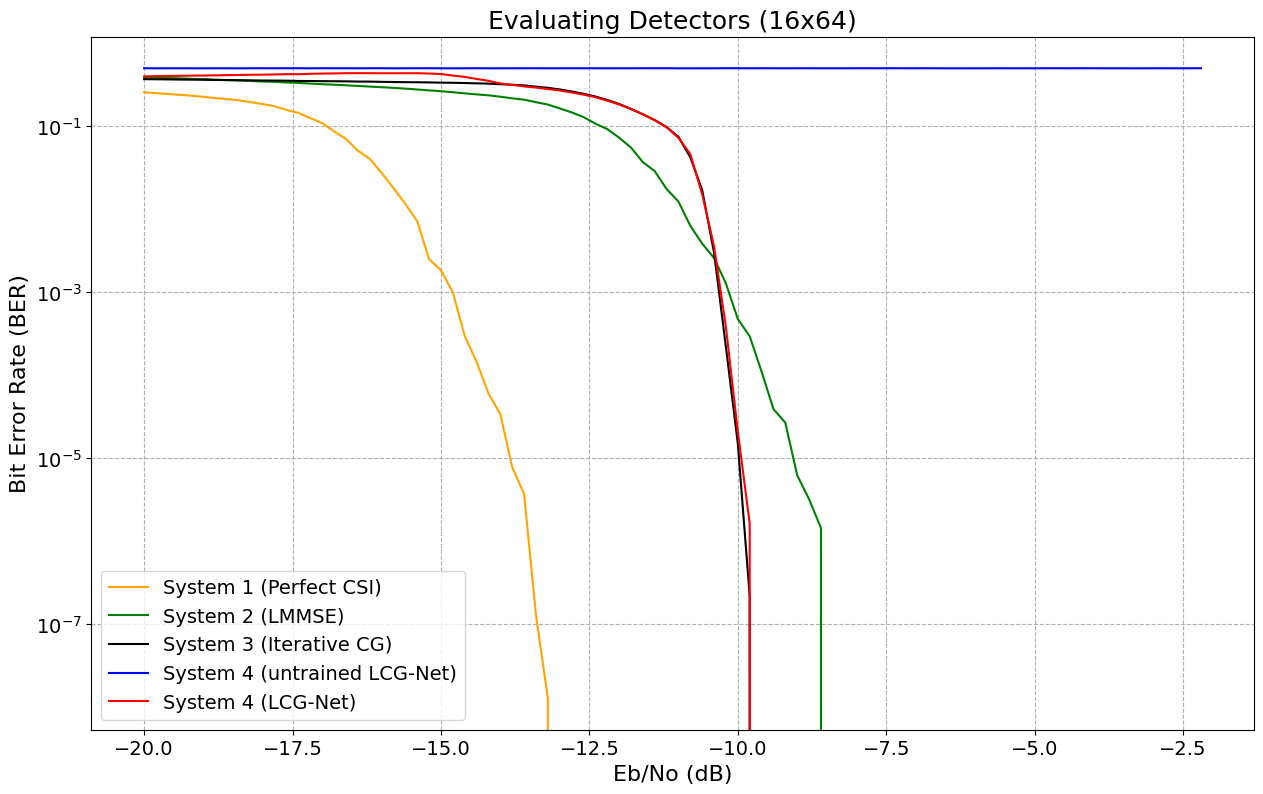

In [72]:
plt.figure(figsize=(15, 9))
plt.semilogy(ebno_dbs, SIM['Perfect_csi_ber'],  '-',color='orange', label='System 1 (Perfect CSI)')
plt.semilogy(ebno_dbs, SIM['ls_equalizer_ber'],  '-',color='green', label='System 2 (LMMSE)')
plt.semilogy(ebno_dbs, SIM['CG_ber'],  '-', color='black',label='System 3 (Iterative CG)')
plt.semilogy(ebno_dbs, SIM['Untrained_LCG_ber'],  '-', color='blue',label='System 4 (untrained LCG-Net)')
plt.semilogy(ebno_dbs, SIM['LCG_Net_ber'], '-', color='red', label='System 4 (LCG-Net)')
font_size= 16
plt.xlabel('Eb/No (dB)', fontsize=font_size)
plt.ylabel('Bit Error Rate (BER)', fontsize=font_size)
plt.title('Evaluating Detectors (16x64)', fontsize=font_size + 2 )
plt.xticks(fontsize=font_size - 2 )
plt.yticks(fontsize=font_size - 2 )
plt.grid(True, which='both', linestyle='--')

plt.legend(fontsize=font_size - 2)

In [ ]:
ber_plots = PlotBER("Advanced Detectors")

In [ ]:
# Computing and plotting BER
ber_plots.simulate(model2,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=50,
                  legend="LCG Network",
                  # soft_estimates=True,
                  max_mc_iter=50,
                  show_fig=False);

In [ ]:
# Computing and plotting BER
baseline_ls = OFDMSystem(False)
ber_plots.simulate(baseline_ls,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=50,
                  legend="LMMSE",
                  # soft_estimates=True,
                  max_mc_iter=50,
                  show_fig=False);

In [ ]:
# Computing and plotting BER
baseline_pcsi = OFDMSystem(True)
ber_plots.simulate(baseline_pcsi,
                  ebno_dbs= ebno_dbs,
                  batch_size = BATCH_SIZE,
                  num_target_block_errors=50,
                  legend="Perfect CSI",
                  max_mc_iter=50,
                  show_fig=True);

In [57]:
def evaluate_nmse_per_layer(model, snr_db_range, batch_size=BATCH_SIZE):
    all_nmse_per_snr = {}

    for ebno_db in snr_db_range:
        print(f"Evaluating at Eb/No = {ebno_db} dB")

        # Forward pass (with b passed for NMSE calculation)
        
        x_hat, no_eff, nmse_layers = model(batch_size= batch_size, ebno_db=ebno_db, nmse_vs_layer= True)
        
        all_nmse_per_snr[ebno_db] = nmse_layers

    return all_nmse_per_snr

In [58]:
def plot_nmse_per_layer(all_nmse_per_snr, sub_fig):  
    
    for snr_db, nmse_list in sorted(all_nmse_per_snr.items()):
        sub_fig.plot(nmse_list, label=f"SNR = {snr_db} dB", marker='o')

Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB
Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part


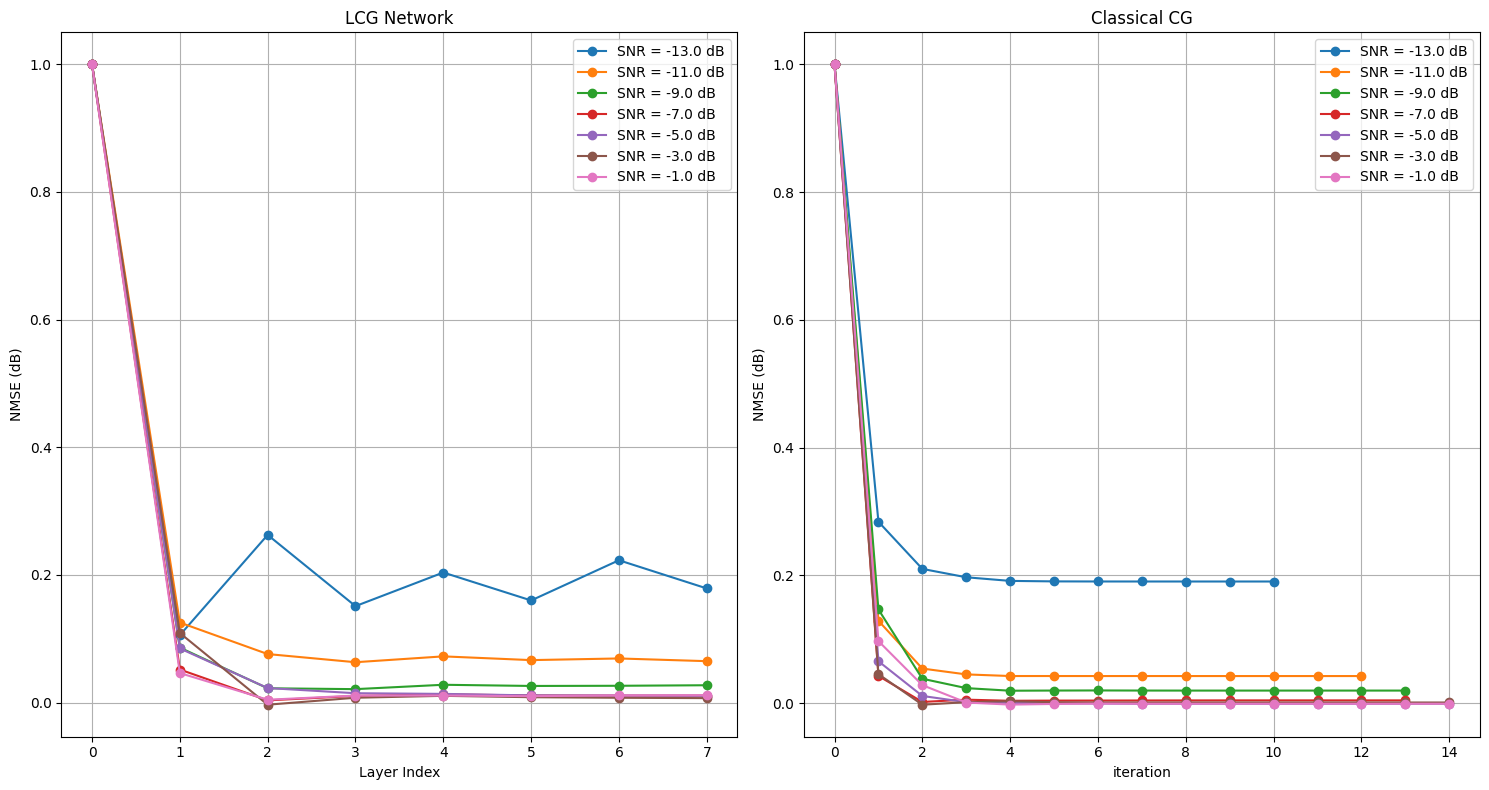

In [59]:
ebno_dbs2 = np.arange(-13.0, # Min SNR for evaluation
                     0.0, # Max SNR for evaluation
                     2)
fig, axs = plt.subplots(1, 2, figsize=(15, 8)) 

# Evaluate
all_nmse_per_snr1 = evaluate_nmse_per_layer(model2, ebno_dbs2, batch_size=BATCH_SIZE)
all_nmse_per_snr2 = evaluate_nmse_per_layer(system, ebno_dbs2, batch_size=BATCH_SIZE)

# Plot
plot_nmse_per_layer(all_nmse_per_snr1, axs[0])
axs[0].set_title("LCG Network")
axs[0].set_xlabel("Layer Index")
axs[0].set_ylabel("NMSE (dB)")
axs[0].grid(True)
axs[0].legend()

plot_nmse_per_layer(all_nmse_per_snr2, axs[1])
axs[1].set_title("Classical CG")
axs[1].set_xlabel("iteration")
axs[1].set_ylabel("NMSE (dB)")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

In [60]:
def plot_nmse_per_layer_independent(all_nmse_per_snr):
    plt.figure(figsize=(10, 6))
    
    for snr_db, nmse_list in sorted(all_nmse_per_snr.items()):
        plt.plot(nmse_list, label=f"SNR = {snr_db} dB", marker='o')

    plt.xlabel("Layer Index")
    plt.ylabel("NMSE (dB)")
    plt.title("NMSE per Layer at Different SNRs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Evaluating at Eb/No = -13.0 dB
Evaluating at Eb/No = -11.0 dB
Evaluating at Eb/No = -9.0 dB
Evaluating at Eb/No = -7.0 dB
Evaluating at Eb/No = -5.0 dB
Evaluating at Eb/No = -3.0 dB
Evaluating at Eb/No = -1.0 dB


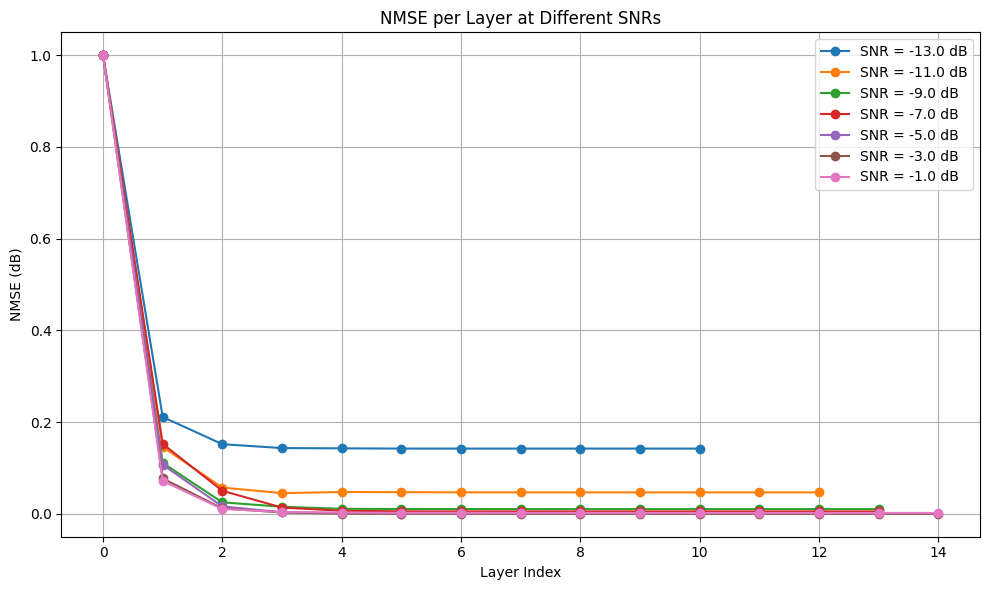

In [61]:
all_nmse_per_snr= evaluate_nmse_per_layer(system, ebno_dbs2, batch_size= BATCH_SIZE)
plot_nmse_per_layer_independent(all_nmse_per_snr)

In [ ]:
def get_throughput(batch_size, ebno_dbs, model, label= "", repetitions=1):
    """ Simulate throughput in bit/s per ebno_dbs point.

    The results are average over `repetition` trials.

    Input
    -----
    batch_size: tf.int32
        Batch-size for evaluation.

    ebno_dbs: tf.float32
        A tensor containing SNR points to be evaluated.

    model:
        Function or model that yields the transmitted bits `u` and the
        receiver's estimate `u_hat` for a given ``batch_size`` and
        ``ebno_db``.

    repetitions: int
        An integer defining how many trails of the throughput
        simulation are averaged.

    """
    throughput = np.zeros_like(ebno_dbs)
    print(f"Testing the Throughput of {label} detector")
    for idx, ebno_db in enumerate(ebno_dbs):

        t_start = time.perf_counter()
        # average over multiple runs
        for _ in range(repetitions):
            u, u_hat = model(batch_size= tf.constant(batch_size, tf.int32),
                             ebno_db= tf.constant(ebno_db, tf. float32))
        t_stop = time.perf_counter()
        # throughput in bit/s
        throughput[idx] = np.size(u.numpy())*repetitions / (t_stop - t_start)
        print(f"Throughput @ {ebno_db:.1f} dB: {throughput[idx]/1e6:.2f} Mbit/s")

    return throughput

In [ ]:
num_repetitions=5
ebno_dbs_ = np.arange(-10.0, # Min SNR for evaluation
                     -7.0, # Max SNR for evaluation
                     0.5)

In [ ]:
throughput_lcg = get_throughput(BATCH_SIZE,
                            ebno_dbs_, # snr point
                            model2,
                            label="LCG Net",
                            repetitions=num_repetitions)

In [ ]:
throughput_cg = get_throughput(BATCH_SIZE,
                            ebno_dbs_, # snr point
                            system,
                            label="CG",
                            repetitions=num_repetitions)

In [ ]:
baseline_ls = OFDMSystem(False)
throughput_ls = get_throughput(BATCH_SIZE,
                            ebno_dbs_, # snr point
                            baseline_ls,
                            label="LMMSE",
                            repetitions=num_repetitions)

In [ ]:
baseline_pcsi = OFDMSystem(True)
throughput_pcsi = get_throughput(BATCH_SIZE,
                            ebno_dbs_, # snr point
                            baseline_pcsi,
                            label="Perfect_CSI",
                            repetitions=num_repetitions)

In [ ]:
avg_throughputs = {
    "LCG Net": sum(throughput_lcg) / len(throughput_lcg),
    "Classical CG": sum(throughput_cg) / len(throughput_cg),
    "LMMSE": sum(throughput_ls) / len(throughput_ls),
    "Perfect CSI": sum(throughput_pcsi) / len(throughput_pcsi)
}

bars = plt.bar(avg_throughputs.keys(), avg_throughputs.values(), color=["green", "blue", "orange", "red"])
plt.ylabel("Average Throughput (Mbit/s)")
plt.title("Average Throughput by Detector")
plt.grid(axis='y')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height/1e6:.2f} Mbit/s', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()